In [1]:
import numpy as np
import cv2
from PIL import Image
import torch
from magic_pen.config import SEED
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from magic_pen.utils_io import load_levircd_sample

from magic_pen.data.loader import BiTemporalDataset
from commons.constants import NamedDataset
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform

from segment_any_change.masks.mask_process import extract_object_from_batch
from segment_any_change.config_run import ExperimentParams, choose_model, load_default_metrics, load_exp_params
from segment_any_change.eval import MetricEngine
from segment_any_change.inference import load_partial_ds
from segment_any_change.config_run import load_default_exp_params
from segment_any_change.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample, load_img
from segment_any_change.inference import partial_inference, infer_on_sample

In [2]:
pair_img = load_levircd_sample(size=None, data_type="test", seed=8)
path_label,path_A, path_B = pair_img.iloc[0]

In [3]:
img_B = load_img(path_B)
img_A = load_img(path_A)

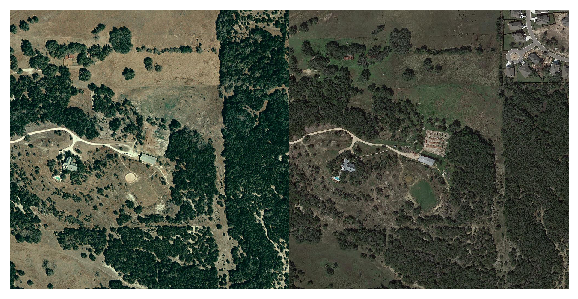

In [4]:
show_pair_img(img_A, img_B)

### Infer on batch

In [5]:
params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=True,
    n_job_by_node=2,
    th_change_proposals=50,
    prompt_type="grid",
    n_prompt=10,
    loc="random",
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95
)
params = load_exp_params(**params)
print(params)

res = partial_inference(params,
    ds_dtype="test",
    dummy=False,
    indices=np.arange(2),
    return_batch=True,
    in_metrics=None)

2024-06-20 14:54:16,445 - INFO ::  build vit_b BiSam


ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=50, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', prompt_type='grid', n_prompt=10, pred_iou_thresh=0.88, stability_score_thresh=0.95, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240620_145416', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')
DATASET SUBSET : 2


Processing:   0%|                                                                                                                  | 0/1 [00:00<?, ?it/s]2024-06-20 14:54:17,978 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
DTYPE input model torch.float32
Function forward Took 6.8623 seconds
sparse_embeddings: torch.Size([4, 9, 2, 256])
dense_embeddings: torch.Size([4, 9, 256, 64, 64])
--in transformer--
src : torch.Size([4, 9, 256, 64, 64])
pos_src : torch.Size([4, 9, 256, 64, 64])
tokens : torch.Size([4, 9, 7, 256])


2024-06-20 14:54:25,792 - INFO ::  Function generate Took 7.8125 seconds
2024-06-20 14:54:25,815 - INFO ::  Function temporal_matching_torch Took 0.0208 seconds
2024-06-20 14:54:25,884 - INFO ::  Function temporal_matching_torch Took 0.0683 seconds
2024-06-20 14:54:25,889 - INFO ::  Function proposal_matching_nms Took 0.0026 seconds
2024-06-20 14:54:25,913 - INFO ::  Function temporal_matching_torch Took 0.0194 seconds
2024-06-20 14:54:25,932 - INFO ::  Function temporal_matching_torch Took 0.0179 seconds
2024-06-20 14:54:25,933 - INFO ::  Function proposal_matching_nms Took 0.0001 seconds
2024-06-20 14:54:25,937 - INFO ::  Function run Took 7.9582 seconds


Function predict_masks_batch Took 0.9249 seconds
OUT MODEL : torch.Size([4, 9, 3, 256, 256])
:: raw masks : 27 ::
 filter iou_th : 7
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
:: raw masks : 27 ::
 filter iou_th : 4
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
:: raw masks : 27 ::
 filter iou_th : 7
 filter stability_score : 2
 filter mask_threshold : 2
ATTACH 2 masks
:: raw masks : 27 ::
 filter iou_th : 4
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
NMS masks fusion
masks torch.Size([2, 2, 256, 256])
masks i A torch.Size([0, 256, 256])
masks i B torch.Size([2, 256, 256])
ci torch.Size([2, 2])
bboxes torch.Size([2, 2, 4])
ious torch.Size([2, 2])
masks_logits torch.Size([2, 2, 256, 256])
NMS masks fusion
masks torch.Size([2, 0, 256, 256])
masks i A torch.Size([0, 256, 256])
masks i B torch.Size([0, 256, 256])
ci torch.Size([2, 0])
bboxes torch.Size([2, 0, 4])
ious torch.Size([2, 0])
masks_logits torch.Size([2,

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.57s/it]


In [6]:
res[0].keys()

dict_keys(['pred', 'metrics', 'batch'])

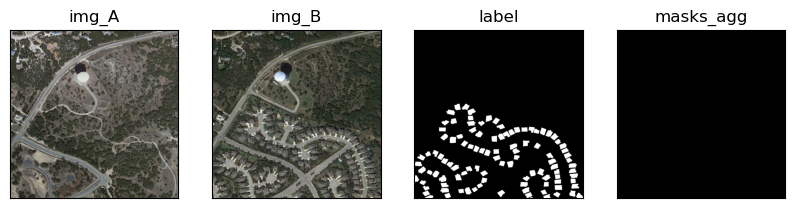

In [10]:
for output in res:
    show_prediction_sample(output, idx=1)

### Infer on sample

In [8]:
pair_img = load_levircd_sample(1, seed=8)
path_label,path_A, path_B = pair_img.iloc[0]

params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=True,
    n_job_by_node=2,
    th_change_proposals=50,
    prompt_type="grid",
    n_prompt=1024,
    loc="random",
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95
)
params = load_exp_params(**params)
print(params)
model = choose_model(is_debug=False, params=params)

output = infer_on_sample(A_path=path_A,
                B_path=path_B, 
                label_path=path_label,
                params=params,
                model=model)

2024-06-20 14:54:26,735 - INFO ::  build vit_b BiSam


ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=50, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', prompt_type='grid', n_prompt=1024, pred_iou_thresh=0.88, stability_score_thresh=0.95, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240620_145426', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


2024-06-20 14:54:28,031 - INFO ::  === v2 ====


BATCH SIZE : 1 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
DTYPE input model torch.float32
Function forward Took 3.4230 seconds
sparse_embeddings: torch.Size([1, 1024, 2, 256])
dense_embeddings: torch.Size([1, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([2, 1024, 256, 64, 64])
pos_src : torch.Size([2, 1024, 256, 64, 64])
tokens : torch.Size([1, 1024, 7, 256])


2024-06-20 14:55:00,667 - INFO ::  Function generate Took 32.6335 seconds


Function predict_masks_batch Took 29.0755 seconds
OUT MODEL : torch.Size([2, 1024, 3, 256, 256])
:: raw masks : 3072 ::
 filter iou_th : 369
 filter stability_score : 94
 filter mask_threshold : 94
ATTACH 58 masks
:: raw masks : 3072 ::
 filter iou_th : 241
 filter stability_score : 77
 filter mask_threshold : 77
ATTACH 57 masks


2024-06-20 14:55:01,421 - INFO ::  Function temporal_matching_torch Took 0.7431 seconds
2024-06-20 14:55:02,147 - INFO ::  Function temporal_matching_torch Took 0.7249 seconds
2024-06-20 14:55:02,155 - INFO ::  Function proposal_matching_nms Took 0.0016 seconds
2024-06-20 14:55:02,183 - INFO ::  Function run Took 34.1507 seconds


NMS masks fusion
masks torch.Size([2, 58, 256, 256])
masks i A torch.Size([58, 256, 256])
masks i B torch.Size([57, 256, 256])
ci torch.Size([2, 58])
bboxes torch.Size([2, 58, 4])
ious torch.Size([2, 58])
masks_logits torch.Size([2, 58, 256, 256])


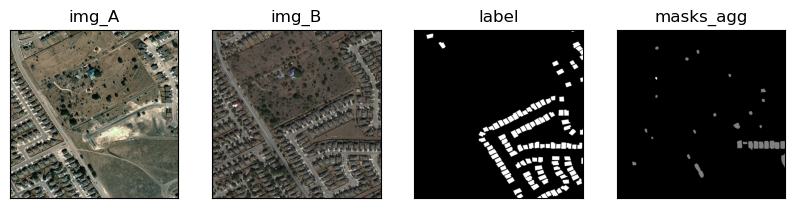

In [9]:
show_prediction_sample(output)

In [52]:
output.keys()

dict_keys(['pred', 'batch'])

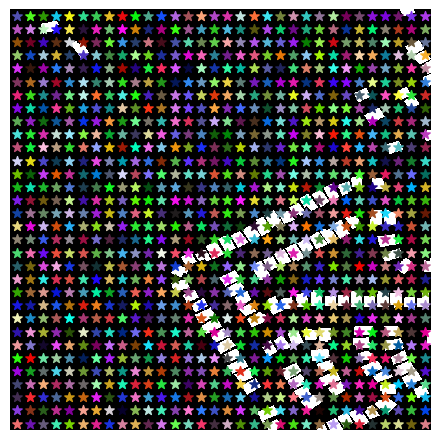

In [53]:
show_img(to_numpy(output["batch"]["label"].squeeze(0) > 0, transpose=False))
ax = plt.gca()

res = output["batch"]["point_coords"].squeeze(0)

color = [np.random.choice(range(256), size=3) / 256 for _ in range(len(res))]

pts = to_numpy(res,transpose=False)
for pt, co in zip(pts, color):
    ax.scatter(*pt, c=[co], marker='*', s=50)

* biais : pour les petits object, le points ont tendances à être samplés sur le bord
* forte variablité de résultats via pred_iou_thresh & pred_iou_thresh => préférer l'exhaustivitée des résultats.
* demander à l'auteur les paramètres utilisés.
* review `compute torchmetrics`